<a href="https://colab.research.google.com/github/ronen-halevy/ai-notebooks/blob/main/notebooks/Building_Tensorflow_Image_Input_Pipeline_using_tfds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Tensorflow Image Pipeline - tf.keras.utils

This page is part of the `Building Tensorflow Image Pipeline` series.

## Introduction

A Neural Network consists of 2 main components: The Input Data Pipeline and the Network Model.

Having that in mind, a major part in the bring up of any Neural Network, besides setting the model itself, is the setting of an efficient input data pipeline.


The costruction of input data pipeline is an `Extract`, `Transform`, `Load` (ETL) task, so it starts with the extraction of data stored in memory or in files(s), continues with transforming it, such that it will have an efficient data format, and then loading it to the model.

In tensorflow, the data should be extracted and arranged as a `tf.data.Dataset` object, and then pass through a list of transformations such as decoding batching, normalizing, resizing, shuffling, augmentating, and so forth.

This series of post presents a variety of imagedata pipeline preparation approches, all aim to provide efficient, multiprocessing capeable, yet simple processing forms. All are alike, in the sense that the output is a `tf.data.Dataset` object.


All posts of this series demonstrate image classification using a common source data and a common model. So, notebooks are almost identical except the input pipeline section.

The source data is `Rock Paper Scissors dataset`, listed in TensorFlow Datasets catalog. The dataset was produced by Lawrance Moroney, million thanks for him on that.


Note that these posts do not aim to demonstrate top-notch classification examples but only to present various input pipeline construction approaches. Accordingly, the network optimal are simple and not optimized.



The posts of this series are: 

1. Image Data Input Pipeline with **tf.keras.utils** **(This post)**

2. Image Data Input Pipeline with tf.data


3. Image Data Input Pipeline with tf.tfds


### About this post

TFDS provides a collection of ready-to-use datasets arranged in a [dataset catalog](https://www.tensorflow.org/datasets/catalog/overview) of easy-to-download datasets at TensorFlow Datasets.

TFDS is a high level wrapper around tf.data, resultant dataset is also a `tf.data.Dataset` object.







In the following we will go step by step through a data classification code, demonstrating dataset creation using the tf.keras.preprocessing.image module.

Code components are:

1. **Import Packages**

2. **Download the data**

3. **Create the dataset** - (Extract and Transform)

4. **Configure the dataset for performance** - (Transform)

5. **Set the model**

6. **Compile the Model**

7. **Train**

8. **Display Model Summary** 

9. **Visualize Training Results***

10. **Run Inference**


...Here we go...!



## 1. Import Packages

In [79]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
import os, random


## 2. Download the data


Here we download the dataset using ***tfds.load***, a convinience method which can be deployed for Tensorflow Datasets. 

In [80]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'rock_paper_scissors',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [81]:
print(metadata)

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)



In [102]:
num_classes = metadata.features['label'].num_classes
print(num_classes)
class_names = metadata.features['label'].names
print(class_names)

3
['rock', 'paper', 'scissors']


***Visualization*** - take a brief look at randomly selected images from each class

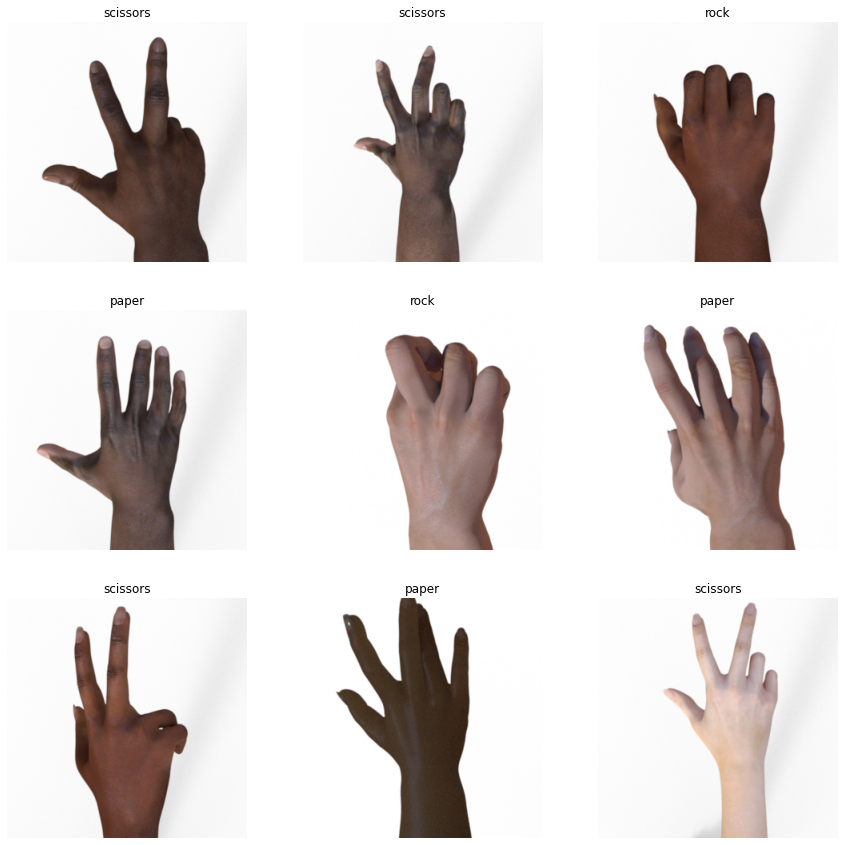

In [82]:
get_label_name = metadata.features['label'].int2str
plt.figure(figsize=(15, 15))
cnt = 0
for image, label in train_ds.take(9):
  cnt += 1
  ax = plt.subplot(3, 3, cnt)
  ax.imshow(image)
  _ = ax.set_title(get_label_name(label))
  _ = ax.axis("off")


## 3. Create the dataset (Extract + Transform)

Having downloaded and extracted the source data files, we we start the creation of data pipeline. 
In this post example, we use the `tf.keras.utils.image_dataset_from_directory` method.

This methods creates a dataset data. The labels are obtained automatically according to the subdirectory name, as shown next. This in addition to more data transformation goodies (detailed next).

**Important note** - the data pipeline operates in the graph mode - see details in the corresponding post (TBD). Accordingly, we first construct the graph which later be triggered with data.


In [83]:
batch_size = 32
image_height = 224
image_width = 224

In [84]:
def format_image(image, label):
    image = tf.image.resize(image, [image_height, image_width]) / 255.0
    return  image, label

train_ds = train_ds.map(format_image)
val_ds = val_ds.map(format_image)
test_ds = test_ds.map(format_image)

Create training dataset:

In [85]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size, drop_remainder=False)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

Examine a single batches shapes:

## 4. Configure the dataset for performance. (Transform)





**Normalize the data**

Standardizes the inputs. This is often integrated within the model, but can also be set on the dataset like so:

**Data Augmentation** - Expand training dataset size

(Find details on Data Augmentation in a related post (TBD))

In [61]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(image_height,
                                  image_width,
                                  3)),
    layers.RandomRotation(0.9, fill_mode="nearest",),
    layers.RandomZoom(0.1),
  ]
)

**Demonstrate Augmentation Visualization**: 

Original image is at upper left, with 8 randomly augmented images. 

Note that dataset is exended to be 4 dims, as expected by the augmentation methods.


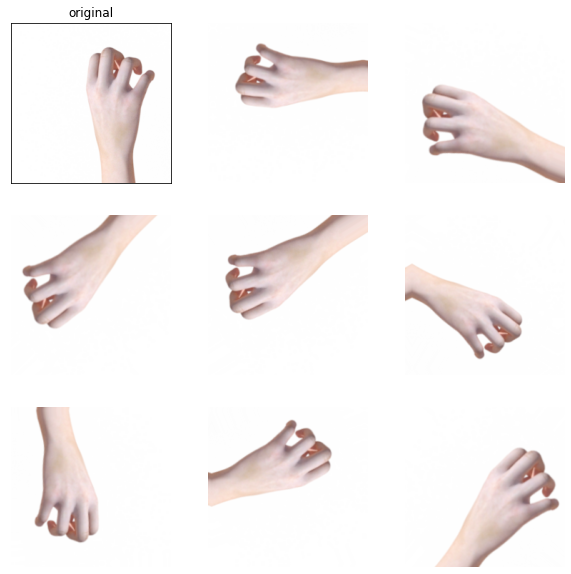

In [88]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  image = images[random.randint(0, len(images)-1)]

  ax = plt.subplot(3, 3, 1)
  ax.set_title('original')
  ax.imshow(image)
  ax.set_xticks([])
  ax.set_yticks([])

  for i in range(8):
    augmented_images = data_augmentation((tf.expand_dims(image, axis=0, name=None)))
    ax = plt.subplot(3, 3, i + 2)
    plt.imshow(augmented_images[0].numpy().astype("float32"))
    plt.axis("off")

Set Augmentation to training dataset

In [89]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

## 5. Set the model

The model consists of 7 layers:
- It begins with 5 convolution blocks, each followed by a max pooling module.

- Then, after flattening the data, convolution blocks are followed by 2 dense layers: 
 - A 128 units dense layer
 - The output layer, with 3 units according to the 3 output classes, i.e.rock, paper, scizors.


In [91]:
num_classes = 3

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding='SAME'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding='SAME'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu', padding='SAME'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu', padding='SAME'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu', padding='SAME'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(num_classes,  activation = 'softmax')
])

<a name='5'></a>
## 6. Compile the Model

- optimizer `adam` - a commonly used stochastic adaptive optimizer.  
- loss function `SparseCategoricalCrossentropy` - commonly used for image classification with more than 2 classes
- from_logits=True - This indicate the loss function that that the output is not normalized, i.e. there is no softmax function at the output. BTW, excluding the softmax function from the model, is considered more numerically stable. The softamx is then added by the loss function module.


In [92]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

## 7. Train the model

Set an Early Stopping Callback

- Stop training when a monitored metric has stopped improving.

- Wait before stopping according `patience` value.

- Restore best waits, after stopping



In [93]:
early_stop_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                min_delta=0, 
                                patience=10, 
                                verbose=1, 
                                mode='auto', 
                                baseline=None, 
                                restore_best_weights=True)

Now do the fit - 30 epochs, with early_stop_cb.

In [94]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop_cb],
)

Epoch 1/30
63/63 [==============================] - 33s 356ms/step - loss: 1.1025 - accuracy: 0.3249 - val_loss: 1.0987 - val_accuracy: 0.3690
Epoch 2/30
63/63 [==============================] - 21s 333ms/step - loss: 1.0863 - accuracy: 0.3829 - val_loss: 1.1379 - val_accuracy: 0.2778
Epoch 3/30
63/63 [==============================] - 21s 341ms/step - loss: 0.9318 - accuracy: 0.5382 - val_loss: 0.9050 - val_accuracy: 0.5437
Epoch 4/30
63/63 [==============================] - 21s 331ms/step - loss: 0.5927 - accuracy: 0.7555 - val_loss: 0.5387 - val_accuracy: 0.7143
Epoch 5/30
63/63 [==============================] - 21s 333ms/step - loss: 0.4008 - accuracy: 0.8403 - val_loss: 0.3797 - val_accuracy: 0.8413
Epoch 6/30
63/63 [==============================] - 21s 330ms/step - loss: 0.3262 - accuracy: 0.8700 - val_loss: 0.3566 - val_accuracy: 0.8571
Epoch 7/30
63/63 [==============================] - 21s 332ms/step - loss: 0.2743 - accuracy: 0.8909 - val_loss: 0.5615 - val_accuracy: 0.7937

## 8. Display model summary

In [95]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)     

## 9 Visualize training results

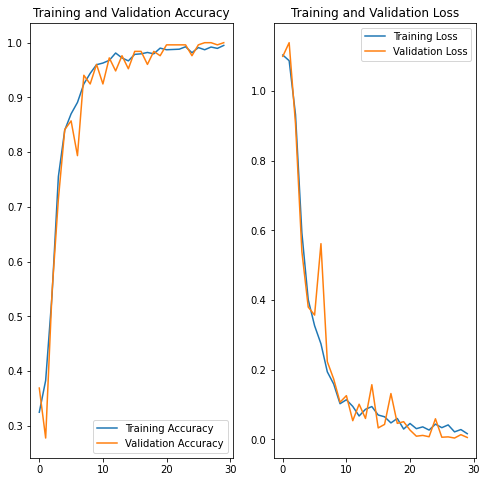

In [96]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 10. Inference


**Download the test dataset from Kaggle and unzip it**

**Run Prediction over The Test Dataset**

In [ ]:
test_ds.

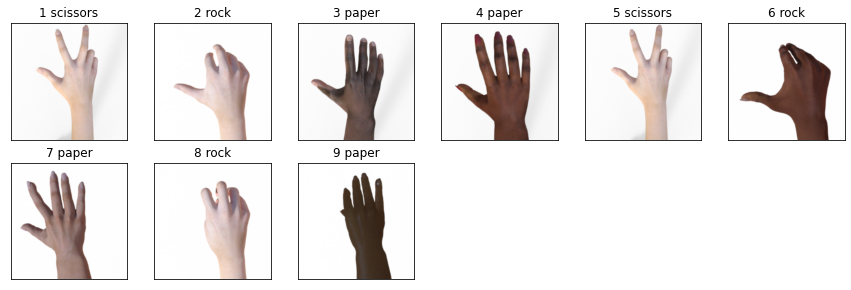

In [105]:
def do_prediction():
    class_name=[]
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    for image_batch, label_batch in test_ds.take(1):
      for idx in range(9):
            image = image_batch[idx]
            ax = fig.add_subplot(6, 6, idx+1)
            ax.imshow(image)
            image = tf.expand_dims(image, axis=0)
            result=model.predict(tf.stack(image, axis=0))
            ax.set_title("{} {}"
              .format(idx+1, class_names[np.argmax(result)])
            )          
            ax.set_xticks([])
            ax.set_yticks([])
    return
do_prediction()


**Examine prediction results**

Here source of test dataset is same as train and validation dataset. Results are just as good.


**Find Accuracy and Loss**
 
Run `model.evaluate` over the test dataset. It calculates loss and accuracy for this data.


In [97]:
results = model.evaluate(test_ds)

print(f'Test {model.metrics_names[0]}: {results[0]} / Test model.metrics_names[1]: {results[1]}')



8/8 [==============================] - 1s 14ms/step - loss: 0.0024 - accuracy: 1.0000
Test loss: 0.002414498943835497 / Test model.metrics_names[1]: 1.0


**Run Prediction On Interactively uploaded Images**

In next notebook cell, you can interactively upload test files(s) and execute inference

Saving sn-scissors.jpg to sn-scissors.jpg
Saving scissors8.jpg to scissors8.jpg
Saving scissors7.jpg to scissors7.jpg
Saving scissors6.jpg to scissors6 (1).jpg
Saving scissors5.jpg to scissors5.jpg
Saving scissors4.jpg to scissors4.jpg
Saving scissors3.jpg to scissors3.jpg
Saving scisors.jpg to scisors.jpg


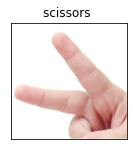

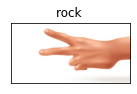

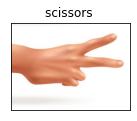

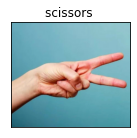

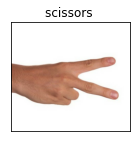

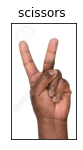

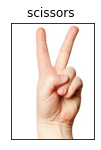

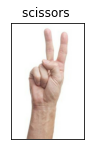

In [108]:
from google.colab import files

uploaded = files.upload()
cnt = 0
for path in uploaded.keys():
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    image = tf.image.resize(img, [image_height, image_width])
    image = tf.expand_dims(image, axis=0)
    image = image / 255.0
    cnt = cnt + 1
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)

    results = model.predict(image)
    result = results[0]
    ax = fig.add_subplot(6, 6, cnt)
    ax.set_title("{} ".format(class_names[np.argmax(result)]))  
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])